In [17]:
!pip install shap

In [18]:
# !ls -l
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.cm import get_cmap
import io
import math
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, QuantileTransformer
from sklearn.metrics import accuracy_score, average_precision_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import plot_confusion_matrix

from xgboost import XGBClassifier
from xgboost import plot_tree
import shap

import seaborn as sns
import pickle

In [19]:
dataDir = '/content/drive/My Drive/00Projects/DNA Repair/prettyFigures/melanoma/data'
figDir = '/content/drive/My Drive/00Projects/DNA Repair/prettyFigures/melanoma/figures'
homeDir = '/content/drive/My Drive/00Projects/DNA Repair/prettyFigures/melanoma'
os.chdir(dataDir)

In [20]:
for f in os.listdir():
  print(f)

parametersFromCV.pickle
parametersFromCV_zero_rows_removed.pickle
64pp_all_DA_normalized.csv
CPD_all_DA_normalized.csv
64pp_5kBTSS_DA_normalized.csv
CPD_5kBTSS_DA_normalized.csv
64pp_5kATSS_DA_normalized.csv
CPD_5kATSS_DA_normalized.csv
64pp_5kBTES_DA_normalized.csv
CPD_5kBTES_DA_normalized.csv
64pp_intergenic_DA_normalized.csv
CPD_intergenic_DA_normalized.csv
singleFeatures_stumps.csv
HeLa_64pp_DA_OneZero.pickle
HeLa_64pp_DA_ShapVal.pickle
HeLa_CPD_DA_OneZero.pickle
HeLa_CPD_DA_ShapVal.pickle
NHF1_64pp_DA_OneZero.pickle
NHF1_64pp_DA_ShapVal.pickle
NHF1_CPD_DA_OneZero.pickle
NHF1_CPD_DA_ShapVal.pickle
GM128_Cisplatin_DA_OneZero.pickle
GM128_Cisplatin_DA_ShapVal.pickle


#Functions

## getRepairDF

In [5]:
def getRepairRegionDF(cellLine, repairType, region, damageSample):
  '''
  repairType: one of ['64pp', 'CPD' or 'Cisplatin']
  region: one of ['all', '5kBTSS', '5kATSS', '5kBTES', 'intergenic']
  damageSample: one of ['DA', 'DB']
  '''
  if cellLine== 'HeLa' or cellLine == 'GM128':
    dataDir = '/content/drive/My Drive/00Projects/DNA Repair/prettyFigures/bothData/data'
  if cellLine == 'NHF1':
    dataDir = '/content/drive/My Drive/00Projects/DNA Repair/prettyFigures/melanoma/data'
  os.chdir(dataDir)
  fname = '.'.join(['_'.join([repairType, region, damageSample, 'normalized']), 'csv'])
  dat = pd.read_csv(fname)
  return dat

## binDF

In [6]:
def binDF(df, numBins):
    binner = KBinsDiscretizer(n_bins=numBins, encode='ordinal', strategy='quantile')
    binner.fit(df)
    binnedDf = binner.transform(df)
    binnedDf = pd.DataFrame(binnedDf)
    binnedDf.columns = df.columns
    return binnedDf

## getTrainTestData

In [7]:
def getTrainTestData(dat, response, chromatin_type):

  '''
  chromtin_type: one of ['All', 'open', 'mid', 'close']
  '''
  
  def binDF(df, numBins):
    binner = KBinsDiscretizer(n_bins=numBins, encode='ordinal', strategy='quantile')
    binner.fit(df)
    binnedDf = binner.transform(df)
    binnedDf = pd.DataFrame(binnedDf)
    binnedDf.columns = df.columns
    return binnedDf


  # if chromatin_type == 'none':    
    # rem0HS = dat[dat.DNAse_I != 0]
    # rpkm = rem0HS.filter(regex='H')
    # X = rpkm.div(rem0HS.DNAse_I, axis=0)    
  # else:
  rpkm = dat.filter(regex='H')
  X = binDF(rpkm, numBins = 4)  #Features
  if chromatin_type != 'All':
    HS = pd.DataFrame(dat['DNAse_I']) # Add HS info 
    binnedHS = binDF(HS, numBins = 3)
    X['binnedHS'] = binnedHS
    X = X.astype({'binnedHS': 'int32'})

  repair = pd.DataFrame(dat[response]) # Bizarize response 
  binnedRep = binDF(repair, numBins = 3)
  X['binnedRep'] = binnedRep
  X = X.astype({'binnedRep': 'int32'})
  X['binnedRep'] = X['binnedRep'].map({0: -1, 1: np.nan, 2:1})
  X = X[X.binnedRep.notnull()]

  y = X['binnedRep']  #Response
  colsToDrop = ['binnedRep']
  x = X.drop(colsToDrop, axis = 1)
  # Put aside test data (contains both open & closed chromatin examples)
  xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, shuffle = False)

  if chromatin_type == 'All':
    return xTrain, xTest, yTrain, yTest
  else:    
    xTest['binnedRep'] = yTest
    # Test data subset based on open/mid/closed chromatin
    if chromatin_type == 'close':  
      xTest_n = xTest[xTest['binnedHS'] == 0]
    elif chromatin_type == 'mid':
      xTest_n = xTest[xTest['binnedHS'] == 1]
    elif chromatin_type == 'open':
      xTest_n = xTest[xTest['binnedHS'] == 2]

    yTest = xTest_n['binnedRep']  
    colsToDrop = ['binnedHS', 'binnedRep']
    xTest_n = xTest_n.drop(colsToDrop, axis = 1)    
    colsToDrop = ['binnedHS']
    xTrain = xTrain.drop(colsToDrop, axis = 1)
    return xTrain, xTest_n, yTrain, yTest

## getAUCForLonePredictors

In [ ]:
 def getAUCForLonePredictors(xTrain, xTest, yTrain, yTest):
  histones = xTrain.columns
  aucs = {}  #hold auc
  for histone in histones:
    xTrain_s = pd.DataFrame(xTrain[histone])
    xTest_s = pd.DataFrame(xTest[histone])
    stump = XGBClassifier(n_estimators=1, max_depth=1)
    stump.fit(xTrain_s, yTrain)
    # predict probabilities
    probs = stump.predict_proba(xTest_s)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate AUC
    auc = roc_auc_score(yTest, probs)
    aucs[histone]=auc
  return aucs

## makeAllAUCPlot

In [ ]:
def makeAllAUCPlot(model, xTrain, xTest, yTrain, yTest, 
                   region, response, chromatin_type):
  model.fit(xTrain, yTrain)
  probs = model.predict_proba(xTest)
  # keep probabilities for the positive outcome only
  probs = probs[:, 1]
  auc = roc_auc_score(yTest, probs)
  print('All AUC: %.3f' % auc)
  fpr, tpr, thresholds = roc_curve(yTest, probs)   
  # plot the roc curve for the model
  ax.plot(fpr, tpr, marker='.',linewidth=1, label=str(region + ' ' + chromatin_type + ': %0.2f') % auc)


## makeLoneAndAllAUCPlots

In [ ]:
def makeLoneAndAllAUCPlots(model, xTrain, xTest, yTrain, yTest, 
                           repair, response, region, chromatin_type):
  rpkms = RPKMs.copy()
  rpkms.append('all')
  aucs = []  #hold auc
  fig,ax = plt.subplots(1)
  # plot no skill
  ax.plot([0, 1], [0, 1], linestyle='--')

  for i, rpkm in enumerate(rpkms):
    if rpkm != 'all':
      xTrain_s = pd.DataFrame(xTrain[rpkm])
      xTest_s = pd.DataFrame(xTest[rpkm])
      stump = XGBClassifier(n_estimators=1, max_depth=1)
      stump.fit(xTrain_s, yTrain)
      # predict probabilities
      probs = stump.predict_proba(xTest_s)
      # keep probabilities for the positive outcome only
      probs = probs[:, 1]
      # calculate AUC
      auc = roc_auc_score(yTest, probs)
      aucs.append(auc)
      print('AUC: %.3f' % auc)
      # calculate roc curve
      fpr, tpr, thresholds = roc_curve(yTest, probs)    
      # plot the roc curve for the stump
      c=next(color)
      ax.plot(fpr, tpr, marker='.', label=str(rpkm + ': %0.2f') % auc, c= c)
      
    else: #plot AUC for all features included together
      model.fit(xTrain, yTrain)
      probs = model.predict_proba(xTest)
      # keep probabilities for the positive outcome only
      probs = probs[:, 1]
      auc = roc_auc_score(yTest, probs)
      aucs.append(auc)
      print('All AUC: %.3f' % auc)
      fpr, tpr, thresholds = roc_curve(yTest, probs)   
      # plot the roc curve for the model
      c=next(color)
      ax.plot(fpr, tpr, marker='.',linewidth=2, label=str(rpkm + ': %0.2f') % auc, c= c)     
    
  # show the plot
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title(str(response)+ ' Test')
  handles,labels = ax.get_legend_handles_labels()
  titleName = [response, chromatin_type, 'Stumps + Best Parameters']
  titleName = ' '.join(titleName)
  ax.set_title(titleName)

  handles,labels = ax.get_legend_handles_labels()
  handles = [x for _,x in sorted(zip(aucs,handles))]
  labels = [x for _,x in sorted(zip(aucs,labels))]

  lgd = ax.legend(handles,labels,loc ="lower right", bbox_to_anchor=(1.41,-0.05))
  figName = [response, chromatin_type, 'Stumps_BestParameters', 'AUC']
  figName = '_'.join(figName)
  plt.savefig( str(figName + '.jpeg'), 
              format='jpeg',
              dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
  plt.show()

In [ ]:
def makeLoneAndAllAUCPlots(model, RPKMs, xTrain, xTest, yTrain, yTest, response, chromatin_type):
  rpkms = RPKMs.copy()
  rpkms.append('all')
  color=iter(cm.rainbow(np.linspace(0,1,17)))
  aucs = []  #hold auc
  fig,ax = plt.subplots(1)
  # plot no skill
  ax.plot([0, 1], [0, 1], linestyle='--')

  for i, rpkm in enumerate(rpkms):
    if rpkm != 'all':
      xTrain_s = pd.DataFrame(xTrain[rpkm])
      xTest_s = pd.DataFrame(xTest[rpkm])
      stump = XGBClassifier(n_estimators=1, max_depth=1)
      stump.fit(xTrain_s, yTrain)
      # predict probabilities
      probs = stump.predict_proba(xTest_s)
      # keep probabilities for the positive outcome only
      probs = probs[:, 1]
      # calculate AUC
      auc = roc_auc_score(yTest, probs)
      aucs.append(auc)
      print('AUC: %.3f' % auc)
      # calculate roc curve
      fpr, tpr, thresholds = roc_curve(yTest, probs)    
      # plot the roc curve for the stump
      c=next(color)
      ax.plot(fpr, tpr, marker='.', label=str(rpkm + ': %0.2f') % auc, c= c)
      
    else: #plot AUC for all features included together
      model.fit(xTrain, yTrain)
      probs = model.predict_proba(xTest)
      # keep probabilities for the positive outcome only
      probs = probs[:, 1]
      auc = roc_auc_score(yTest, probs)
      aucs.append(auc)
      print('All AUC: %.3f' % auc)
      fpr, tpr, thresholds = roc_curve(yTest, probs)   
      # plot the roc curve for the model
      c=next(color)
      ax.plot(fpr, tpr, marker='.',linewidth=2, label=str(rpkm + ': %0.2f') % auc, c= c)     
    
  # show the plot
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title(str(response)+ ' Test')
  handles,labels = ax.get_legend_handles_labels()
  titleName = [response, chromatin_type, 'Stumps + Best Parameters']
  titleName = ' '.join(titleName)
  ax.set_title(titleName)

  handles,labels = ax.get_legend_handles_labels()
  handles = [x for _,x in sorted(zip(aucs,handles))]
  labels = [x for _,x in sorted(zip(aucs,labels))]

  lgd = ax.legend(handles,labels,loc ="lower right", bbox_to_anchor=(1.41,-0.05))
  figName = [response, chromatin_type, 'Stumps_BestParameters', 'AUC']
  figName = '_'.join(figName)
  plt.savefig( str(figName + '.jpeg'), 
              format='jpeg',
              dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
  plt.show()

## shap

In [ ]:
def shap(model,xTest,region, response, chromatin_type):
  import shap
  # explain the model's predictions using SHAP values
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(xTest)
  # summarize the effects of all the features
  fig = shap.summary_plot(shap_values, xTest, show= False, plot_type = 'bar')
  figName = '_'.join([region, response, chromatin_type, 'shap', 'bar'])
  figName = '.'.join([figName, 'jpeg'])
  plt.savefig(figName, format='jpeg', dpi=500, bbox_inches='tight')
  plt.show()

## getBestParamDict

In [12]:
def getBestParamDict(cellLine, region, response, damageSample):
  '''
  '''
  repair = response.split('_')[0]
  key = '_'.join([repair, region, damageSample, response])

  if cellLine == 'HeLa' or cellLine == 'GM128':
    homeDir = '/content/drive/My Drive/00Projects/DNA Repair/prettyFigures/bothData/'
    os.chdir(homeDir)
    with open('parametersFromCV_64pp.pickle', 'rb') as handle:
        params_64pp = pickle.load(handle)
    with open('parametersFromCV_CPD.pickle', 'rb') as handle:
        params_CPD = pickle.load(handle)
    with open('parametersFromCV_Cisplatin.pickle', 'rb') as handle:
        params_Cisplatin = pickle.load(handle)

  if cellLine == 'NHF1':
    dataDir = '/content/drive/My Drive/00Projects/DNA Repair/prettyFigures/melanoma/data'
    os.chdir(dataDir)
    with open('parametersFromCV_zero_rows_removed.pickle', 'rb') as handle:
      params_nhf1 = pickle.load(handle)

  
  if cellLine == 'NHF1':
    bestParamDict = params_nhf1[key]
  else:
    if '64pp' in response:    
      bestParamDict = params_64pp[key]
    elif 'CPD' in response:
      bestParamDict = params_CPD[key]  
    elif 'Cisplatin' in response:
      bestParamDict = params_Cisplatin[key]
                        
  return bestParamDict

# Figure 1: Distributions

Starting 64pp
Starting damage DA
Region all
Response 64pp_A
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3', 'H3K79me2', 'H3K4me2', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3']
Region 5kBTSS
Response 64pp_A
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3', 'H3K79me2', 'H3K4me2', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3']
Region 5kATSS
Response 64pp_A
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3', 'H3K79me2', 'H3K4me2', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3']
Region 5kBTES
Response 64pp_A
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3', 'H3K79me2', 'H3K4me2', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3']
Region intergenic
Response 64pp_A
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3', 'H3K79me2', 'H3K4me2', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3']


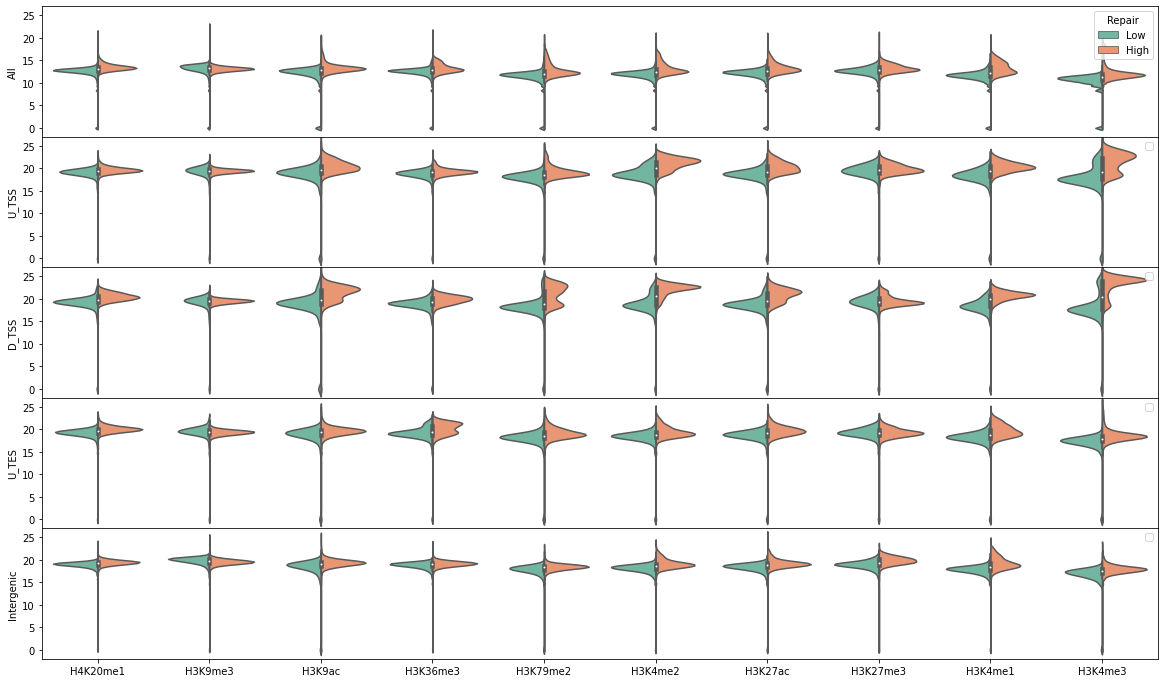

Starting CPD
Starting damage DA
Region all
Response CPD_A
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3', 'H3K79me2', 'H3K4me2', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3']
Region 5kBTSS
Response CPD_A
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3', 'H3K79me2', 'H3K4me2', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3']
Region 5kATSS
Response CPD_A
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3', 'H3K79me2', 'H3K4me2', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3']
Region 5kBTES
Response CPD_A
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3', 'H3K79me2', 'H3K4me2', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3']
Region intergenic
Response CPD_A
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3', 'H3K79me2', 'H3K4me2', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3']


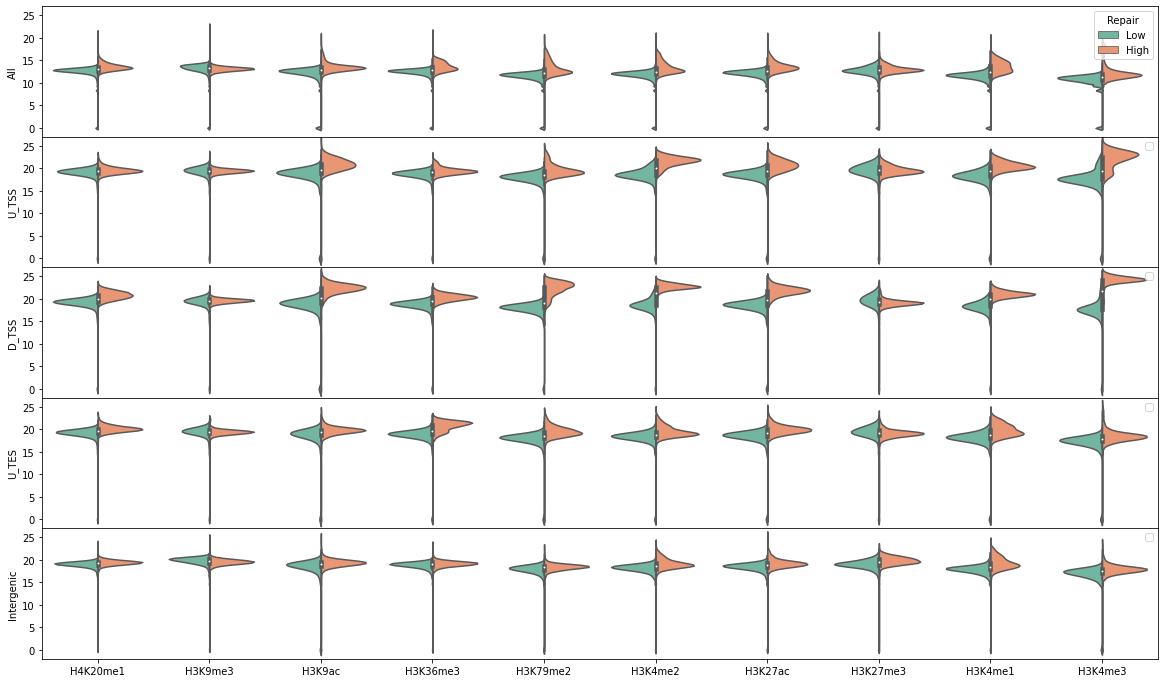

In [ ]:
repairTypes = ['64pp', 'CPD']
repairName = ['(6-4)PP, CPD']
regions = ['all','5kBTSS', '5kATSS', '5kBTES', 'intergenic']
regionLabels = ['All','U_TSS', 'D_TSS', 'U_TES', 'Intergenic']
# regions = ['intergenic']
damageSamples = ['DA']

for repairType in repairTypes:
  print('Starting', repairType)

  for damageSample in damageSamples:
    print('Starting damage', damageSample)

    #initialize 5 plots for 5 regions
    fig, axs = plt.subplots(nrows=len(regions), ncols=1,figsize=(20, 12),sharex=True,
                            gridspec_kw=dict( hspace=0))     


    for i, region in enumerate(regions):
      print('Region', region)
      dat = getRepairRegionDF(repairType, region, damageSample)
      responses = ['_'.join([repairType, 'A'])] #single response enough because 
                                                #HMs don't change between samples

      rpkm = dat.filter(regex='H')
      rpkm_log = np.log2(rpkm+1) # +1 to prevent log(0) errors

      for response in responses:
        print('Response', response)

        repair = pd.DataFrame(dat[response]) # Bizarize response 
        Repair = binDF(repair, numBins = 3)
        rpkm_log['Repair'] = Repair
        rpkm_log = rpkm_log.astype({'Repair': 'int32'})
        rpkm_log['Repair'] = rpkm_log['Repair'].map({0: -1, 1: np.nan, 2:1})
        rpkm_log = rpkm_log[rpkm_log.Repair.notnull()]


        value_vars = list(rpkm_log.columns)[:-1]
        print(value_vars)
        df = pd.melt(rpkm_log, 
                id_vars=['Repair'], 
                value_vars=value_vars)
        df['Repair'] = df['Repair'].map({-1.0: 'Low', 1.0: 'High'})

        sns.violinplot(x="variable", y="value", hue ='Repair',  
                      data=df, split=True, hue_order=['Low', 'High' ], 
                      palette="Set2", ax=axs[i])
        axs[i].set_ylabel(regionLabels[i])
        axs[i].set_xlabel('')
        axs[i].set_ylim((-2,27))
        if i > 0:
          axs[i].legend("")
        
    extensions = ['jpeg', 'pdf']
    # extensions = ['jpeg']
    for ext in extensions:
      figName = '.'.join(['_'.join([repairType, damageSample, 'violinPlot']), ext])
      figDir_name = os.path.join(figDir, figName)
      plt.savefig(figDir_name, bbox_inches='tight', dpi=500)
    plt.show()

### RPKM discrete distribution

['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3', 'H3K79me2', 'H3K4me2', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3', 'H3K79me2', 'H3K4me2', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3', 'H3K79me2', 'H3K4me2', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3', 'H3K79me2', 'H3K4me2', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3']
['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3', 'H3K79me2', 'H3K4me2', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3']


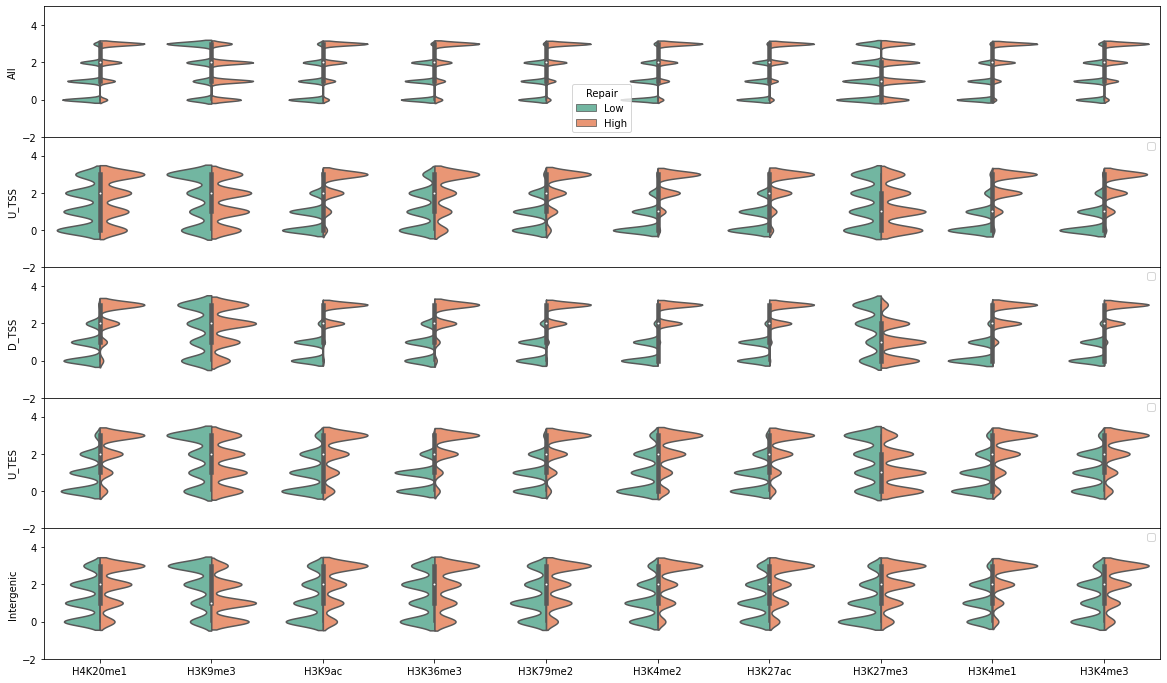

In [ ]:
repairTypes = ['CPD']
regions = regions = ['all','5kBTSS', '5kATSS', '5kBTES', 'intergenic']
regionLabels = ['All','U_TSS', 'D_TSS', 'U_TES', 'Intergenic']
damageSamples = ['DA']


for repairType in repairTypes:
  response = '_'.join([repairType, 'A'])
  for damageSample in damageSamples:
    fig, axs = plt.subplots(nrows = len(regions), ncols = 1,
                            figsize=(20, 12),sharex=True,
                            gridspec_kw=dict( hspace=0))
    for i, region in enumerate(regions):
      dat = getRepairRegionDF(repairType, region, damageSample)
      hists = dat.filter(regex='H', axis =1)
      hists = binDF(hists, 4)
      
      repair = pd.DataFrame(dat[response])
      repair = binDF(repair, 3)

      hists['Repair'] = repair

      hists = hists.astype({'Repair': 'int32'})
      hists['Repair'] = hists['Repair'].map({0: -1, 1: np.nan, 2:1})
      hists = hists[hists.Repair.notnull()]

      value_vars = list(hists.columns)[:-1]
      print(value_vars)
      df = pd.melt(hists, id_vars=['Repair'], value_vars=value_vars)
      df['Repair'] = df['Repair'].map({-1.0:'Low', 1.0:'High'})

      sns.violinplot(x = 'variable', y = 'value', hue='Repair',
                     data = df, split= True, hue_order=['Low', 'High'],
                     palette='Set2', ax=axs[i])
      axs[i].set_ylabel(regionLabels[i])
      axs[i].set_xlabel('')
      axs[i].set_ylim((-2,5))
      if i>0:
        axs[i].legend('')
      
    extensions = ['jpeg', 'pdf']
    for ext in extensions:
      figName = '.'.join(['_'.join([repairType, damageSample, 'discrete_violinplot']), ext])
      plt.savefig(os.path.join(figDir, figName), bbox_inches='tight', dpi=500)
    plt.show()

# Figure 2: Predictions on whole genome

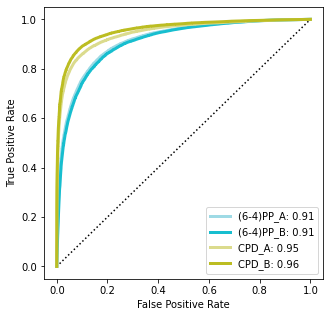

In [16]:
repairTypes = ['64pp','CPD']
repairNames = ['(6-4)PP', 'CPD']
regions = ['all']
damageSamples =['DA']
cellline = 'NHF1'
name = "tab20"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = list(reversed(cmap.colors))  # type: list
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(5,5))
ax.set_prop_cycle(color=colors)
ax.plot([0,1], [0,1], linestyle= ':', c='k')
for i, repairType in enumerate(repairTypes):
  for damageSample in damageSamples:
    for region in regions:
      dat = getRepairRegionDF(cellline, repairType, region, damageSample)
      responses = ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]
      responsesNames = ['_'.join([repairNames[i], 'A']), '_'.join([repairNames[i], 'B'])]
      for j, response in enumerate(responses):
        paramToUseDict = getBestParamDict(cellline,region,response,damageSample)
        myClassifier = XGBClassifier(max_depth=paramToUseDict['max_depth'],
                                     min_child_weight=paramToUseDict['min_child_weight'],
                                     subsample = paramToUseDict['subsample'],
                                     gamma = paramToUseDict["gamma"],
                                     n_estimators = paramToUseDict["n_estimators"])
        chromatin_types = ['All']
        for chromatin_type in chromatin_types:
          xTrain, xTest, yTrain, yTest = getTrainTestData(dat, response, chromatin_type)
          myClassifier.fit(xTrain, yTrain)
          probs = myClassifier.predict_proba(xTest)
          probs = probs[:, 1] # keep probabilities for the positive outcome only
          auc = roc_auc_score(yTest, probs)
          fpr, tpr, thresholds = roc_curve(yTest, probs)          
          ax.plot(fpr,tpr,linewidth=3, 
                  label=str( responsesNames[j] + ': %0.2f') % auc)
        
handles,labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles,labels,loc ="lower right")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

extensions = ['jpeg', 'pdf']
for ext in extensions:
  figName = '.'.join(['_'.join([cellline,'Chromatin', chromatin_type,
                                'BestParameters','AUC']), ext])
  figDir_name = os.path.join(figDir, figName)
  plt.savefig(figDir_name, bbox_inches='tight', dpi=500,
            bbox_extra_artists=(lgd,))
plt.show() 

# Figure 2: Decision stumps for whole genome

### dataframe (for all genomic regions)

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
loneAUCs = {}
repairTypes = ['64pp', 'CPD']
damageSamples = ['DA']
regions = ['all','5kBTSS', '5kATSS', '5kBTES', 'intergenic']
chromatin_types = ['All','open', 'close']
for repairType in repairTypes:
  for damageSample in damageSamples:
    for region in regions:
      dat = getRepairRegionDF(repairType, region, damageSample)
      responses = ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]
      for response in responses:        
        for chromatin_type in chromatin_types:
          xTrain, xTest, yTrain, yTest = getTrainTestData(dat, response, chromatin_type)
          thisSample = '_'.join([damageSample, region, response, chromatin_type])
          loneAUCs[thisSample] = getAUCForLonePredictors(xTrain, xTest, yTrain, yTest)
df = pd.DataFrame(data = loneAUCs)
df.to_csv('singleFeatures_stumps.csv')

In [21]:
loneAUCs = pd.read_csv('singleFeatures_stumps.csv', index_col=0)
loneAUCs.head()

,DA_all_64pp_A_All,DA_all_64pp_A_open,DA_all_64pp_A_close,DA_all_64pp_B_All,DA_all_64pp_B_open,DA_all_64pp_B_close,DA_5kBTSS_64pp_A_All,DA_5kBTSS_64pp_A_open,DA_5kBTSS_64pp_A_close,DA_5kBTSS_64pp_B_All,DA_5kBTSS_64pp_B_open,DA_5kBTSS_64pp_B_close,DA_5kATSS_64pp_A_All,DA_5kATSS_64pp_A_open,DA_5kATSS_64pp_A_close,DA_5kATSS_64pp_B_All,DA_5kATSS_64pp_B_open,DA_5kATSS_64pp_B_close,DA_5kBTES_64pp_A_All,DA_5kBTES_64pp_A_open,DA_5kBTES_64pp_A_close,DA_5kBTES_64pp_B_All,DA_5kBTES_64pp_B_open,DA_5kBTES_64pp_B_close,DA_intergenic_64pp_A_All,DA_intergenic_64pp_A_open,DA_intergenic_64pp_A_close,DA_intergenic_64pp_B_All,DA_intergenic_64pp_B_open,DA_intergenic_64pp_B_close,DA_all_CPD_A_All,DA_all_CPD_A_open,DA_all_CPD_A_close,DA_all_CPD_B_All,DA_all_CPD_B_open,DA_all_CPD_B_close,DA_5kBTSS_CPD_A_All,DA_5kBTSS_CPD_A_open,DA_5kBTSS_CPD_A_close,DA_5kBTSS_CPD_B_All,DA_5kBTSS_CPD_B_open,DA_5kBTSS_CPD_B_close,DA_5kATSS_CPD_A_All,DA_5kATSS_CPD_A_open,DA_5kATSS_CPD_A_close,DA_5kATSS_CPD_B_All,DA_5kATSS_CPD_B_open,DA_5kATSS_CPD_B_close,DA_5kBTES_CPD_A_All,DA_5kBTES_CPD_A_open,DA_5kBTES_CPD_A_close,DA_5kBTES_CPD_B_All,DA_5kBTES_CPD_B_open,DA_5kBTES_CPD_B_close,DA_intergenic_CPD_A_All,DA_intergenic_CPD_A_open,DA_intergenic_CPD_A_close,DA_intergenic_CPD_B_All,DA_intergenic_CPD_B_open,DA_intergenic_CPD_B_close
H4K20me1,0.736451,0.648266,0.687351,0.732391,0.638176,0.683479,0.635108,0.637327,0.690851,0.634045,0.626611,0.692442,0.765206,0.636404,0.658282,0.749427,0.647723,0.615096,0.750884,0.671739,0.728226,0.733311,0.632440,0.728289,0.658573,0.617423,0.585175,0.665837,0.579049,0.636378,0.737551,0.678397,0.667033,0.737534,0.616985,0.721325,0.587299,0.637596,0.627608,0.611982,0.696013,0.700763,0.798788,0.781320,0.469684,0.807769,0.735552,0.500281,0.732737,0.607410,0.725931,0.749452,0.707843,0.738723,0.636153,0.550727,0.617117,0.620441,0.486154,0.614976
H3K9me3,0.596627,0.533151,0.557814,0.595533,0.527329,0.551339,0.568768,0.536652,0.623262,0.571160,0.530217,0.649917,0.563823,0.524123,0.627685,0.563441,0.525176,0.614313,0.618350,0.590127,0.632661,0.626820,0.606011,0.660731,0.608858,0.529585,0.571316,0.603609,0.519102,0.567814,0.603117,0.538868,0.579115,0.613111,0.545393,0.585807,0.562141,0.472265,0.659375,0.553088,0.450166,0.652368,0.558145,0.471197,0.156977,0.562457,0.573278,0.257303,0.557395,0.522792,0.557998,0.581386,0.598039,0.584131,0.584661,0.542909,0.507684,0.596970,0.547223,0.550242
H3K9ac,0.653923,0.652616,0.537847,0.692543,0.617912,0.614977,0.732883,0.585771,0.529858,0.735058,0.615616,0.524211,0.782586,0.574561,0.518976,0.776738,0.639516,0.527208,0.603985,0.612772,0.510887,0.619602,0.599308,0.542831,0.615647,0.581950,0.560351,0.642283,0.577830,0.595603,0.704602,0.720052,0.571629,0.711580,0.732382,0.573701,0.842074,0.749692,0.576188,0.841589,0.740864,0.532479,0.919794,0.625000,0.485465,0.945452,0.857143,0.488764,0.645084,0.674796,0.570351,0.657001,0.686520,0.580235,0.589250,0.526364,0.512984,0.592766,0.575727,0.500966
H3K36me3,0.655683,0.618408,0.615622,0.652425,0.613064,0.613910,0.585203,0.546119,0.506312,0.593666,0.557143,0.522425,0.705278,0.515351,0.461753,0.701434,0.586820,0.482191,0.669831,0.616486,0.647446,0.683082,0.602382,0.715893,0.555086,0.586149,0.542719,0.575030,0.624619,0.562959,0.754749,0.723523,0.753241,0.750985,0.717191,0.762767,0.648678,0.633513,0.618118,0.652194,0.595515,0.619436,0.863014,0.709732,0.449128,0.869986,0.813454,0.546629,0.854540,0.818542,0.880930,0.846760,0.779657,0.892701,0.591303,0.607273,0.558956,0.582642,0.602201,0.554106
H3K79me2,0.670065,0.647145,0.590704,0.665253,0.638664,0.587803,0.705478,0.528590,0.543262,0.699000,0.551786,0.518895,0.770069,0.575877,0.484407,0.759068,0.637048,0.498310,0.657648,0.596105,0.610349,0.679216,0.617027,0.616522,0.604165,0.572297,0.583772,0.593609,0.573054,0.536789,0.763431,0.756017,0.708099,0.761986,0.754317,0.710163,0.743166,0.743683,0.622695,0.738417,0.695183,0.624482,0.913127,0.698266,0.691030,0.935343,0.917245,0.774719,0.749444,0.784519,0.723292,0.746602,0.753431,0.735580,0.613783,

## figure

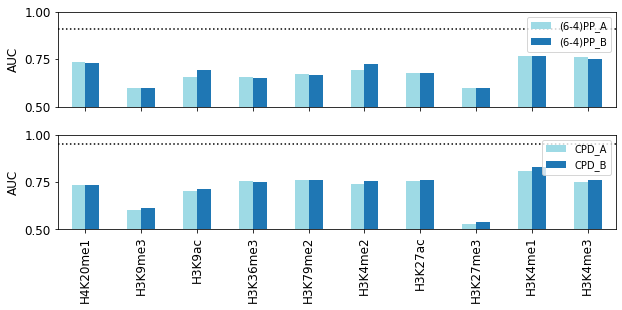

In [62]:
repairTypes = ['64pp', 'CPD']
repairNames = ['(6-4)PP', 'CPD']
allAUC= [0.91, 0.95]
damageSamples = ['DA']
regions = ['all']
chromatin_type = 'All'
cellline = 'NHF1'

# name = "tab10"
# cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
# colors = list(reversed(cmap.colors))  # type: list

for region in regions:
  fig, ax = plt.subplots(nrows=len(repairTypes), ncols=1, figsize=(10,4),
                            sharex = True, sharey='row',
                            gridspec_kw=dict(hspace=0.3, wspace = 0))
  for i, repairType in enumerate(repairTypes):
    for damageSample in damageSamples:
      responses = ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]
      responsesNames = ['_'.join([repairNames[i], 'A']), '_'.join([repairNames[i], 'B'])]
      cols = ['_'.join([damageSample, region, responses[0], chromatin_type]),
              '_'.join([damageSample, region, responses[1], chromatin_type])]

      thisRepairAUCs = loneAUCs[cols]
      ax[i].set_ylabel("AUC", fontsize=12)
      thisRepairAUCs.plot(kind='bar', fontsize=12, cmap='tab20_r', ax= ax[i])
      ax[i].legend(([responsesNames[0], responsesNames[1]]), loc=1)      
      ax[i].set_ylim(0.5, 1)
      ymin, ymax = ax[i].get_ylim()
      N=3 #num of ticks
      ax[i].set_yticks(np.round(np.linspace(ymin, ymax, N), 2))
      ax[i].axhline(allAUC[i], linestyle = ':', c='k')
  extensions = ['jpeg', 'pdf']
  for ext in extensions:
    figName = '.'.join(['_'.join([cellline,'LoneHistones', 
                                  'Chromatin', chromatin_type, 
                                  'region',region, 
                                  'Stump', 'AUC']), ext])
    figDir_name = os.path.join(figDir, figName)
    plt.savefig(figDir_name, bbox_inches='tight', dpi=500)
  plt.show()    

# Figure 3: open and closed chromatin predictions

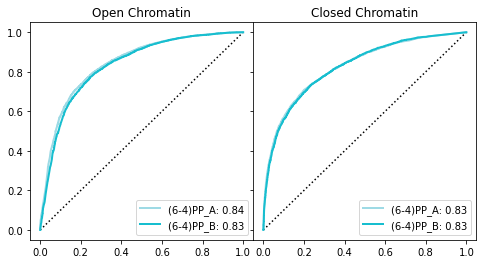

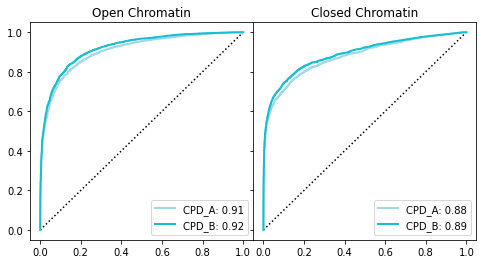

In [65]:
# Stop that pesky warning
pd.options.mode.chained_assignment = None  # default='warn'
os.chdir(dataDir)
repairTypes = ['64pp', 'CPD']
repairNames = ['(6-4)PP', 'CPD']
# repairTypes = ['A64']
regions = ['all']
regionLabels = ['All Genomic Regions']
damageSamples = ['DA']
chromatin_types = ['open', 'close']
cellline = 'NHF1'

for i, repairType in enumerate(repairTypes):
  responses = ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]
  responsesNames = ['_'.join([repairNames[i], 'A']), '_'.join([repairNames[i], 'B'])]
  for damageSample in damageSamples:    
    name = "tab20"
    cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
    colors = list(reversed(cmap.colors))  # type: list
    fig, ax = plt.subplots(nrows=len(regions), ncols=2, figsize=(8,4),
                          sharex = True, sharey='row',
                          gridspec_kw=dict(hspace=0, wspace = 0))                              
    for region in regions:
      dat = getRepairRegionDF(cellline, repairType, region, damageSample)
      for j, chromatin_type in enumerate(chromatin_types):
        ax[j].set_prop_cycle(color=colors)
        ax[j].plot([0, 1], [0, 1], linestyle=':', c='k') # plot no skill
        for k, response in enumerate(responses):
          paramToUseDict = getBestParamDict(cellline, region, response, damageSample)
          myClassifier = XGBClassifier(max_depth = paramToUseDict["max_depth"],
                                        min_child_weight = paramToUseDict["min_child_weight"],
                                        subsample = paramToUseDict["subsample"],
                                        gamma = paramToUseDict["gamma"],
                                        n_estimators = paramToUseDict["n_estimators"]) 
          xTrain, xTest, yTrain, yTest = getTrainTestData(dat, response, chromatin_type)
          myClassifier.fit(xTrain, yTrain)
          probs = myClassifier.predict_proba(xTest)
          probs = probs[:, 1]
          auc = roc_auc_score(yTest, probs)
          fpr, tpr, thresholds = roc_curve(yTest, probs)   
          ax[j].plot(fpr, tpr,linewidth=2, 
                      label=str( responsesNames[k] + ': %0.2f') % auc)
        if j == 0:
          ax[j].set_title('Open Chromatin')
        if j == 1:
          ax[j].set_title('Closed Chromatin')        
        # if j == 0: 
        #   ax[j].set_ylabel(regionLabels[0])
        handles,labels = ax[j].get_legend_handles_labels()
        lgd = ax[j].legend(handles,labels,loc ="lower right")
    
    extensions = ['jpeg', 'pdf']
    for ext in extensions:
      figName = '.'.join(['_'.join([cellline, repairType, damageSample, 
                                    'OpenClose','BestParameters', 'AUC']), ext])
      figDir_name = os.path.join(figDir, figName)
      plt.savefig(figDir_name, bbox_inches='tight', dpi=500,
                  bbox_extra_artists=(lgd,))
    plt.show()    

# Figure 3: Decision stumps for open & closed chromatin

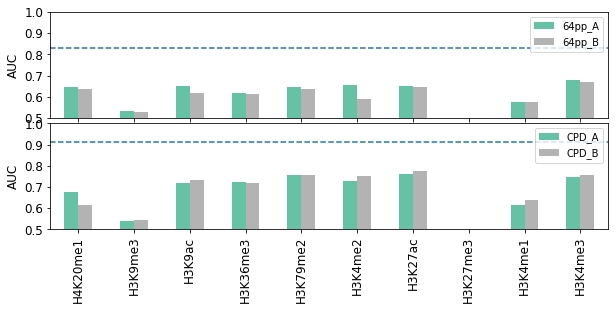

In [ ]:
repairTypes = ['64pp', 'CPD']
allAUC= [0.83, 0.91]
damageSamples = ['DA']
regions = ['all']
chromatin_type = 'open'
cellline = 'NHF1'

name = "tab10"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = list(reversed(cmap.colors))  # type: list

for region in regions:
  fig, ax = plt.subplots(nrows=len(repairTypes), ncols=1, figsize=(10,4),
                            sharex = True, sharey='row',
                            gridspec_kw=dict(hspace=0.05, wspace = 0))
  for i, repairType in enumerate(repairTypes):
    for damageSample in damageSamples:
      responses = ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]
      cols = ['_'.join([damageSample, region, responses[0], chromatin_type]),
              '_'.join([damageSample, region, responses[1], chromatin_type])]

      thisRepairAUCs = loneAUCs[cols]
      
      ax[i].set_ylabel("AUC", fontsize=12)
      thisRepairAUCs.plot(kind='bar', fontsize=12, cmap='Set2', ax= ax[i])
      ax[i].legend(([responses[0], responses[1]]), loc=1)
      
      ax[i].set_ylim(0.5, 1)
      ax[i].axhline(allAUC[i], linestyle = '--')
  extensions = ['jpeg', 'pdf']
  for ext in extensions:
    figName = '.'.join(['_'.join([cellline,'LoneHistones', 
                                  'Chromatin', chromatin_type, 
                                  'region',region, 
                                  'Stump', 'AUC']), ext])
    figDir_name = os.path.join(figDir, figName)
    plt.savefig(figDir_name, bbox_inches='tight', dpi=500)
  plt.show()    

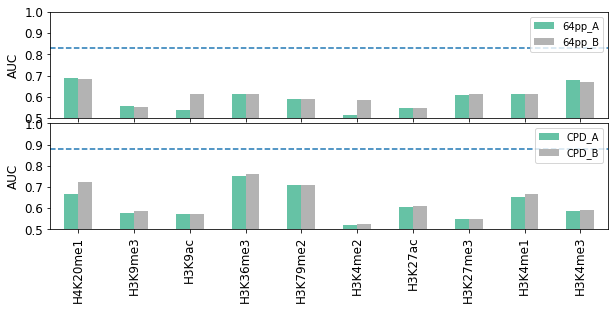

In [ ]:
repairTypes = ['64pp', 'CPD']
allAUC= [0.83, 0.88]
damageSamples = ['DA']
regions = ['all']
chromatin_type = 'close'
cellline = 'NHF1'

name = "tab10"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = list(reversed(cmap.colors))  # type: list

for region in regions:
  fig, ax = plt.subplots(nrows=len(repairTypes), ncols=1, figsize=(10,4),
                            sharex = True, sharey='row',
                            gridspec_kw=dict(hspace=0.05, wspace = 0))
  for i, repairType in enumerate(repairTypes):
    for damageSample in damageSamples:
      responses = ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]
      cols = ['_'.join([damageSample, region, responses[0], chromatin_type]),
              '_'.join([damageSample, region, responses[1], chromatin_type])]

      thisRepairAUCs = loneAUCs[cols]
      
      ax[i].set_ylabel("AUC", fontsize=12)
      thisRepairAUCs.plot(kind='bar', fontsize=12, cmap='Set2', ax= ax[i])
      ax[i].legend(([responses[0], responses[1]]), loc=1)
      
      ax[i].set_ylim(0.5, 1)
      ax[i].axhline(allAUC[i], linestyle = '--')
  extensions = ['jpeg', 'pdf']
  for ext in extensions:
    figName = '.'.join(['_'.join([cellline,'LoneHistones', 
                                  'Chromatin', chromatin_type, 
                                  'region',region, 
                                  'Stump', 'AUC']), ext])
    figDir_name = os.path.join(figDir, figName)
    plt.savefig(figDir_name, bbox_inches='tight', dpi=500)
  plt.show()    

# Figure 4: predictions for genomic regions

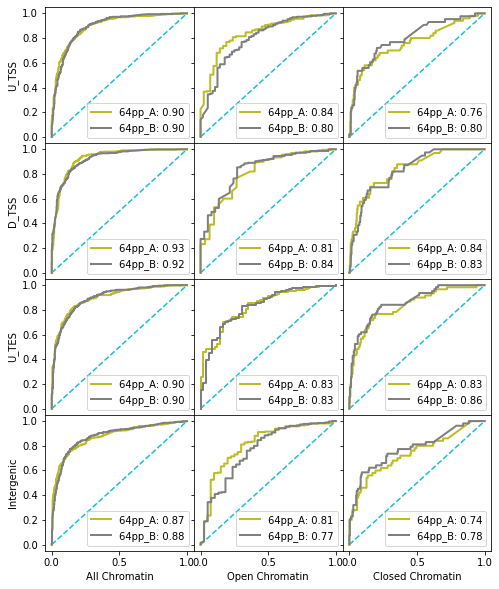

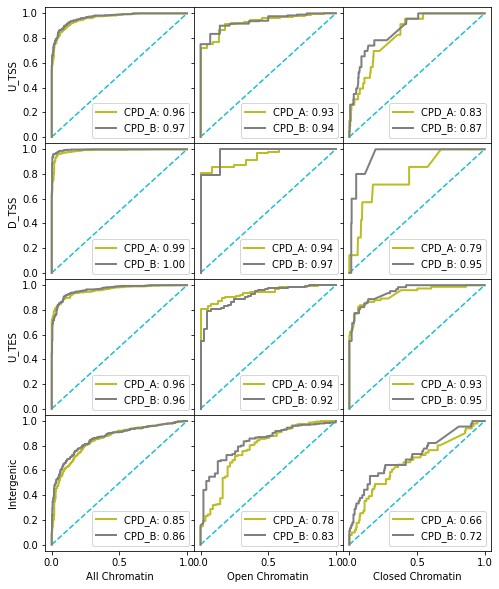

In [ ]:
# Stop that pesky warning
pd.options.mode.chained_assignment = None  # default='warn'
os.chdir(dataDir)
cellLine = 'NHF1'
repairTypes = ['64pp', 'CPD']
# repairTypes = ['A64']
regions = ['5kBTSS', '5kATSS', '5kBTES', 'intergenic']
regionLabels = ['U_TSS', 'D_TSS', 'U_TES', 'Intergenic']
damageSamples = ['DA']
chromatin_types = ['All', 'open', 'close']

for repairType in repairTypes:
  responses = ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]
  for damageSample in damageSamples:    
    name = "tab10"
    cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
    colors = list(reversed(cmap.colors))  # type: list
    fig, ax = plt.subplots(nrows=len(regions), ncols=3, figsize=(8,10),
                          sharex = True, sharey='row',
                          gridspec_kw=dict(hspace=0, wspace = 0))
                          
    for i, region in enumerate(regions):
      dat = getRepairRegionDF(repairType, region, damageSample)
      for j, chromatin_type in enumerate(chromatin_types):  
        ax[i,j].set_prop_cycle(color=colors)
        ax[i,j].plot([0, 1], [0, 1], linestyle='--') # plot no skill              
        for k, response in enumerate(responses):
          paramToUseDict = getBestParamDict(region, response, damageSample)
          myClassifier = XGBClassifier(max_depth = paramToUseDict["max_depth"],
                                        min_child_weight = paramToUseDict["min_child_weight"],
                                        subsample = paramToUseDict["subsample"],
                                        gamma = paramToUseDict["gamma"],
                                        n_estimators = paramToUseDict["n_estimators"])          
          xTrain, xTest, yTrain, yTest = getTrainTestData(dat, response, chromatin_type)
          myClassifier.fit(xTrain, yTrain)
          probs = myClassifier.predict_proba(xTest)            
          probs = probs[:, 1] # keep probabilities for the positive outcome only
          auc = roc_auc_score(yTest, probs)
          fpr, tpr, thresholds = roc_curve(yTest, probs)   
          ax[i,j].plot(fpr, tpr,linewidth=2, 
                      label=str( response + ': %0.2f') % auc)
        if j == 0:
          ax[i,j].set_xlabel('All Chromatin')
        if j == 1:
          ax[i,j].set_xlabel('Open Chromatin')
        if j == 2:
          ax[i,j].set_xlabel('Closed Chromatin')          
        if j == 0: 
          ax[i,j].set_ylabel(regionLabels[i])
        handles,labels = ax[i,j].get_legend_handles_labels()
        lgd = ax[i,j].legend(handles,labels,loc ="lower right")    
    extensions = ['jpeg', 'pdf']
    # extensions = ['jpeg']
    for ext in extensions:
      figName = '.'.join(['_'.join([cellLine, repairType, damageSample, 
                                    'GenomicRegions','BestParameters', 
                                    'AUC']), ext])
      figDir_name = os.path.join(figDir, figName)
      plt.savefig(figDir_name, bbox_inches='tight', dpi=500,
                  bbox_extra_artists=(lgd,))
    plt.show()    

# Figure 4: decision stumps for genomic regions

In [ ]:
loneAUCs = pd.read_csv('singleFeatures_stumps.csv', index_col=0)
loneAUCs.head()

,DA_all_64pp_A_All,DA_all_64pp_A_open,DA_all_64pp_A_close,DA_all_64pp_B_All,DA_all_64pp_B_open,DA_all_64pp_B_close,DA_5kBTSS_64pp_A_All,DA_5kBTSS_64pp_A_open,DA_5kBTSS_64pp_A_close,DA_5kBTSS_64pp_B_All,DA_5kBTSS_64pp_B_open,DA_5kBTSS_64pp_B_close,DA_5kATSS_64pp_A_All,DA_5kATSS_64pp_A_open,DA_5kATSS_64pp_A_close,DA_5kATSS_64pp_B_All,DA_5kATSS_64pp_B_open,DA_5kATSS_64pp_B_close,DA_5kBTES_64pp_A_All,DA_5kBTES_64pp_A_open,DA_5kBTES_64pp_A_close,DA_5kBTES_64pp_B_All,DA_5kBTES_64pp_B_open,DA_5kBTES_64pp_B_close,DA_intergenic_64pp_A_All,DA_intergenic_64pp_A_open,DA_intergenic_64pp_A_close,DA_intergenic_64pp_B_All,DA_intergenic_64pp_B_open,DA_intergenic_64pp_B_close,DA_all_CPD_A_All,DA_all_CPD_A_open,DA_all_CPD_A_close,DA_all_CPD_B_All,DA_all_CPD_B_open,DA_all_CPD_B_close,DA_5kBTSS_CPD_A_All,DA_5kBTSS_CPD_A_open,DA_5kBTSS_CPD_A_close,DA_5kBTSS_CPD_B_All,DA_5kBTSS_CPD_B_open,DA_5kBTSS_CPD_B_close,DA_5kATSS_CPD_A_All,DA_5kATSS_CPD_A_open,DA_5kATSS_CPD_A_close,DA_5kATSS_CPD_B_All,DA_5kATSS_CPD_B_open,DA_5kATSS_CPD_B_close,DA_5kBTES_CPD_A_All,DA_5kBTES_CPD_A_open,DA_5kBTES_CPD_A_close,DA_5kBTES_CPD_B_All,DA_5kBTES_CPD_B_open,DA_5kBTES_CPD_B_close,DA_intergenic_CPD_A_All,DA_intergenic_CPD_A_open,DA_intergenic_CPD_A_close,DA_intergenic_CPD_B_All,DA_intergenic_CPD_B_open,DA_intergenic_CPD_B_close
H4K20me1,0.736451,0.648266,0.687351,0.732391,0.638176,0.683479,0.635108,0.637327,0.690851,0.634045,0.626611,0.692442,0.765206,0.636404,0.658282,0.749427,0.647723,0.615096,0.750884,0.671739,0.728226,0.733311,0.632440,0.728289,0.658573,0.617423,0.585175,0.665837,0.579049,0.636378,0.737551,0.678397,0.667033,0.737534,0.616985,0.721325,0.587299,0.637596,0.627608,0.611982,0.696013,0.700763,0.798788,0.781320,0.469684,0.807769,0.735552,0.500281,0.732737,0.607410,0.725931,0.749452,0.707843,0.738723,0.636153,0.550727,0.617117,0.620441,0.486154,0.614976
H3K9me3,0.596627,0.533151,0.557814,0.595533,0.527329,0.551339,0.568768,0.536652,0.623262,0.571160,0.530217,0.649917,0.563823,0.524123,0.627685,0.563441,0.525176,0.614313,0.618350,0.590127,0.632661,0.626820,0.606011,0.660731,0.608858,0.529585,0.571316,0.603609,0.519102,0.567814,0.603117,0.538868,0.579115,0.613111,0.545393,0.585807,0.562141,0.472265,0.659375,0.553088,0.450166,0.652368,0.558145,0.471197,0.156977,0.562457,0.573278,0.257303,0.557395,0.522792,0.557998,0.581386,0.598039,0.584131,0.584661,0.542909,0.507684,0.596970,0.547223,0.550242
H3K9ac,0.653923,0.652616,0.537847,0.692543,0.617912,0.614977,0.732883,0.585771,0.529858,0.735058,0.615616,0.524211,0.782586,0.574561,0.518976,0.776738,0.639516,0.527208,0.603985,0.612772,0.510887,0.619602,0.599308,0.542831,0.615647,0.581950,0.560351,0.642283,0.577830,0.595603,0.704602,0.720052,0.571629,0.711580,0.732382,0.573701,0.842074,0.749692,0.576188,0.841589,0.740864,0.532479,0.919794,0.625000,0.485465,0.945452,0.857143,0.488764,0.645084,0.674796,0.570351,0.657001,0.686520,0.580235,0.589250,0.526364,0.512984,0.592766,0.575727,0.500966
H3K36me3,0.655683,0.618408,0.615622,0.652425,0.613064,0.613910,0.585203,0.546119,0.506312,0.593666,0.557143,0.522425,0.705278,0.515351,0.461753,0.701434,0.586820,0.482191,0.669831,0.616486,0.647446,0.683082,0.602382,0.715893,0.555086,0.586149,0.542719,0.575030,0.624619,0.562959,0.754749,0.723523,0.753241,0.750985,0.717191,0.762767,0.648678,0.633513,0.618118,0.652194,0.595515,0.619436,0.863014,0.709732,0.449128,0.869986,0.813454,0.546629,0.854540,0.818542,0.880930,0.846760,0.779657,0.892701,0.591303,0.607273,0.558956,0.582642,0.602201,0.554106
H3K79me2,0.670065,0.647145,0.590704,0.665253,0.638664,0.587803,0.705478,0.528590,0.543262,0.699000,0.551786,0.518895,0.770069,0.575877,0.484407,0.759068,0.637048,0.498310,0.657648,0.596105,0.610349,0.679216,0.617027,0.616522,0.604165,0.572297,0.583772,0.593609,0.573054,0.536789,0.763431,0.756017,0.708099,0.761986,0.754317,0.710163,0.743166,0.743683,0.622695,0.738417,0.695183,0.624482,0.913127,0.698266,0.691030,0.935343,0.917245,0.774719,0.749444,0.784519,0.723292,0.746602,0.753431,0.735580,0.613783,

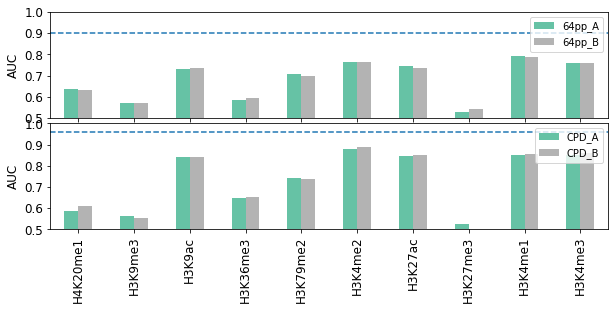

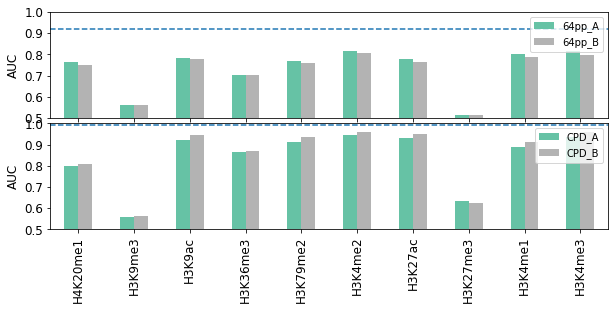

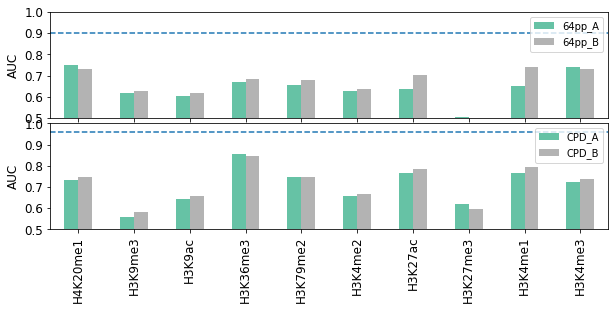

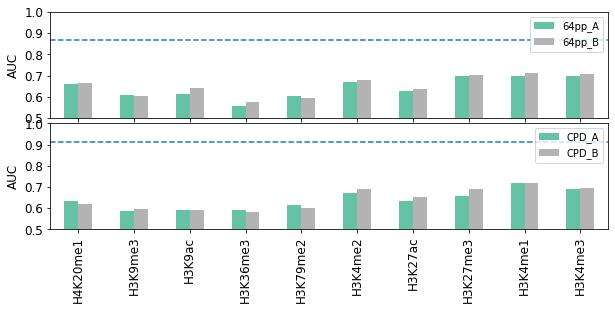

In [ ]:
repairTypes = ['64pp', 'CPD']
# allAUC= [0.86, 0.96]
damageSamples = ['DA']
# regions = ['all']
regions = ['5kBTSS', '5kATSS', '5kBTES', 'intergenic']
chromatin_type = 'All'

name = "tab10"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = list(reversed(cmap.colors))  # type: list

for region in regions:
  if region == '5kBTSS':
    allAUC= [0.90, 0.96]
  if region == '5kATSS':
    allAUC= [0.92, 0.99]
  if region == '5kBTES':
    allAUC= [0.90, 0.96]
  if region == 'intergenic':
    allAUC= [0.87, 0.91]
  if region == 'all':
    allAUC= [0.91, 0.95]
  
  fig, ax = plt.subplots(nrows=len(repairTypes), ncols=1, figsize=(10,4),
                            sharex = True, sharey='row',
                            gridspec_kw=dict(hspace=0.05, wspace = 0))
  for i, repairType in enumerate(repairTypes):
    for damageSample in damageSamples:
      responses = ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]
      cols = ['_'.join([damageSample, region, responses[0], chromatin_type]),
              '_'.join([damageSample, region, responses[1], chromatin_type])]

      thisRepairAUCs = loneAUCs[cols]
      
      ax[i].set_ylabel("AUC", fontsize=12)
      thisRepairAUCs.plot(kind='bar', fontsize=12, cmap='Set2', ax= ax[i])
      ax[i].legend(([responses[0], responses[1]]), loc=1)
      
      ax[i].set_ylim(0.5, 1)
      ax[i].axhline(allAUC[i], linestyle = '--')
  extensions = ['jpeg', 'pdf']
  # extensions = ['jpeg']
  for ext in extensions:
    figName = '.'.join(['_'.join([cellLine,'LoneHistones', 
                                  'Chromatin', chromatin_type, 
                                  'region',region, 
                                  'Stump', 'AUC']), ext])
    figDir_name = os.path.join(figDir, figName)
    plt.savefig(figDir_name, bbox_inches='tight', dpi=500)
  plt.show()    

# Shap values

In [66]:
cellLines = ['HeLa', 'GM128', 'NHF1']
# cellLines = ['HeLa', 'GM128', 'NHF1']
# repairTypes = ['CPD']
regions = ['all', '5kBTSS', '5kATSS', '5kBTES', 'intergenic']
# regions = ['5kBTSS']
damageSamples = ['DA']
chromatin_types = ['All', 'open', 'close']

In [67]:
# Stop that pesky warning
pd.options.mode.chained_assignment = None  # default='warn'

for cellLine in cellLines:
  if cellLine == 'GM128':
    repairTypes = ['Cisplatin']
    histones = ['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1',
                    'H3K79me2', 'H2AFZ', 'H3K4me2', 'H3K27ac', 'H3K27me3_1', 
                    'H3K4me1','H3K4me3_1', 'H3K4me3_2', 'H3K27me3_2', 'H3K36me3_2']
    # dataDir = '/content/drive/My Drive/00Projects/DNA Repair/prettyFigures/bothData/data'    
  elif cellLine=='HeLa':
    repairTypes = ['64pp', 'CPD']
    histones = ['H4K20me1', 'H3K9me3', 'H3K9ac', 'H3K36me3_1', 'H3K79me2', 'H2AFZ',
                'H3K4me2', 'H3K27ac', 'H3K27me3_1', 'H3K4me1', 'H3K4me3_1', 
                'H3K4me3_2', 'H3K4me3_3', 'H3K27me3_2', 'H3K36me3_2']
    # dataDir = '/content/drive/My Drive/00Projects/DNA Repair/prettyFigures/bothData/data'    
  elif cellLine == 'NHF1':
    repairTypes = ['64pp', 'CPD']
    histones = ['H4K20me1', 'H3K9me3','H3K9ac', 'H3K36me3', 'H3K79me2', 
                    'H3K4me2', 'H3K27ac', 'H3K27me3','H3K4me1', 'H3K4me3'] 
    # dataDir = '/content/drive/My Drive/00Projects/DNA Repair/prettyFigures/melanoma/data'
  for repairType in repairTypes:
    for damageSample in damageSamples:
      thisRepairOneZeroDF = pd.DataFrame(columns=histones)
      thisRepairShapValDF = pd.DataFrame(columns=histones)
      
      for i, region in enumerate(regions):
        dat = getRepairRegionDF(cellLine, repairType, region, damageSample)
        responses = ['_'.join([repairType, 'A']), '_'.join([repairType, 'B'])]

        for j, response in enumerate(responses):
          paramToUseDict = getBestParamDict(cellLine, region, response, damageSample)
          myClassifier = XGBClassifier(max_depth = paramToUseDict["max_depth"],
                                        min_child_weight = paramToUseDict["min_child_weight"],
                                        subsample = paramToUseDict["subsample"],
                                        gamma = paramToUseDict["gamma"],
                                        n_estimators = paramToUseDict["n_estimators"])       
          
          thisRespRegShapPos = [0] * len(histones) #hold top shap positions
          thisRespRegShapVal = [0] * len(histones) #hold top shap values        
          
          for chromatin_type in chromatin_types:
            thisRespRegIndexName = '_'.join([cellLine, response, region, damageSample, chromatin_type])

            xTrain, xTest, yTrain, yTest = getTrainTestData(dat, response, chromatin_type)
            # histones = list(xTest.columns)
            myClassifier.fit(xTrain, yTrain)

            explainer = shap.TreeExplainer(myClassifier)
            shap_values = explainer.shap_values(xTest)       
            shapValues = pd.DataFrame(shap_values)
            shapValues.columns = xTest.columns
            global_shap_values = np.abs(shapValues).mean(0)
            
            global_shap_values2 = global_shap_values.sort_values(ascending=False) 
            global_shap_values2 = pd.DataFrame(global_shap_values2).reset_index()
            global_shap_values2.columns = ['histone', 'meanAbsSHAP']        
            
            for i, hist in enumerate(histones):
              thisHistIndex = global_shap_values2.index[global_shap_values2['histone'] == hist].tolist()[0]
              thisHistShapVal = global_shap_values2[global_shap_values2['histone']== hist]['meanAbsSHAP'].tolist()[0]
              # if thisHistIndex in [0,1,2,3,4]:
              if thisHistIndex in [0,1,2]:
                thisRespRegShapPos[i] = 1
                thisRespRegShapVal[i] = thisHistShapVal

            thisRespRegShapPos = pd.Series(thisRespRegShapPos, 
                                          name = thisRespRegIndexName, 
                                          index=histones) 
            thisRespRegShapVal = pd.Series(thisRespRegShapVal, 
                                          name = thisRespRegIndexName, 
                                          index=histones)
            thisRepairOneZeroDF = thisRepairOneZeroDF.append(thisRespRegShapPos)
            thisRepairShapValDF = thisRepairShapValDF.append(thisRespRegShapVal)
    
    fnameOneZero = '.'.join(['_'.join([cellLine, repairType, damageSample, 'OneZero']), 'pickle'])
    fnameShapVal = '.'.join(['_'.join([cellLine, repairType, damageSample, 'ShapVal']), 'pickle'])
    dataDir = '/content/drive/My Drive/00Projects/DNA Repair/prettyFigures/melanoma/data'
    os.chdir(dataDir)
    with open(fnameOneZero, 'wb') as handle:
        pickle.dump(thisRepairOneZeroDF, handle)
    with open(fnameShapVal, 'wb') as handle:
        pickle.dump(thisRepairShapValDF, handle)

# with open('globalShapValues.pickle', 'rb') as handle:
#     shapVals = pickle.load(handle)

FileNotFoundError: ignored

In [ ]:
dat.head()

,chr,start,end,H4K20me1,H3K9me3,H3K9ac,H3K36me3_1,H3K79me2,H2AFZ,H3K4me2,H3K27ac,H3K27me3_1,H3K4me1,H3K4me3_1,H3K4me3_2,H3K27me3_2,H3K36me3_2,DNAse_I,Cisplatin_A,Cisplatin_B
0,chr1,2945000,2950000,1.056481e+06,6.230530e+05,216714.072870,1.544088e+06,135446.295544,433428.145740,135446.295544,81267.777326,1.164838e+06,1.110660e+06,1.056481e+06,379249.627523,1.950427e+06,216714.072870,1.920628e+07,0.462766,0.372340
1,chr1,4110000,4115000,7.584993e+05,8.397670e+05,379249.627523,1.219017e+06,162535.554653,568874.441284,216714.072870,54178.518218,1.137749e+06,1.110660e+06,1.598266e+06,460517.404849,2.221319e+06,297981.850196,1.942300e+07,0.346734,0.311558
2,chr1,4540000,4545000,8.126778e+05,2.167141e+06,433428.145740,1.598266e+06,189624.813761,866856.291480,270892.591088,189624.813761,1.408641e+06,1.787891e+06,2.410944e+06,514695.923067,1.869159e+06,514695.923067,2.134634e+07,0.350746,0.350746
3,chr1,4965000,4970000,4.334281e+05,2.302587e+06,433428.145740,1.381552e+06,108357.036435,839767.032372,189624.813761,108357.036435,8.397670e+05,1.977516e+06,2.383855e+06,460517.404849,1.869159e+06,379249.627523,9.616687e+06,0.271028,0.308411
4,chr1,5210000,5215000,1.110660e+06,1.842070e+06,433428.145740,1.029392e+06,216714.072870,352160.368414,81267.777326,81267.777326,8.126778e+05,2.438033e+06,2.383855e+06,650142.218610,2.112962e+06,325071.109305,1.080861e+07,0.252174,0.208696


In [ ]:
!ls -ltr

total 247068
-rw------- 1 root root   1138049 Apr 30 16:43 parametersFromCV.pickle
-rw------- 1 root root      1282 May  6 17:49 parametersFromCV_zero_rows_removed.pickle
-rw------- 1 root root 120199095 May  8 07:46 64pp_all_DA_normalized.csv
-rw------- 1 root root 119668641 May  8 07:48 CPD_all_DA_normalized.csv
-rw------- 1 root root   1492733 May  8 07:49 64pp_5kBTSS_DA_normalized.csv
-rw------- 1 root root   1489579 May  8 07:49 CPD_5kBTSS_DA_normalized.csv
-rw------- 1 root root   1495851 May  8 07:51 64pp_5kATSS_DA_normalized.csv
-rw------- 1 root root   1491421 May  8 07:51 CPD_5kATSS_DA_normalized.csv
-rw------- 1 root root   1490759 May  8 07:52 64pp_5kBTES_DA_normalized.csv
-rw------- 1 root root   1489269 May  8 07:53 CPD_5kBTES_DA_normalized.csv
-rw------- 1 root root   1529147 May  8 07:54 64pp_intergenic_DA_normalized.csv
-rw------- 1 root root   1455868 May  8 07:55 CPD_intergenic_DA_normalized.csv
-rw------- 1 root root     12672 May  8 09:20 singleFeatures_stumps.csv


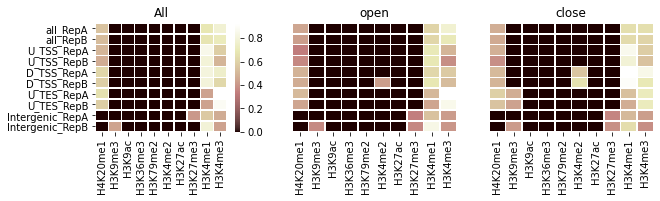

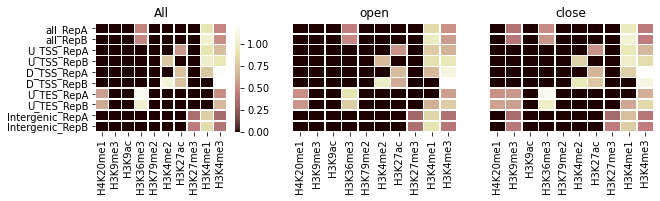

In [72]:
cellLines=['NHF1']
for cellLine in cellLines:
  if cellLine == 'GM128':
    repairTypes = ['Cisplatin']    
  elif cellLine=='HeLa':
    repairTypes = ['64pp', 'CPD']    
  elif cellLine == 'NHF1':
    repairTypes = ['64pp', 'CPD']
  for repairType in repairTypes:
    for damageSample in damageSamples:
      fnameShapVal = '.'.join(['_'.join([cellLine, repairType, damageSample, 'ShapVal']), 'pickle'])
      with open(fnameShapVal, 'rb') as handle:
          shapVal = pickle.load(handle)

      shapVal_annot = shapVal.applymap(lambda x:'' if x==0 else str(x)[:4])
      yTicks = ['all_RepA', 'all_RepB',
                'U_TSS_RepA','U_TSS_RepB',
                'D_TSS_RepA', 'D_TSS_RepB',
                'U_TES_RepA','U_TES_RepB',
                'Intergenic_RepA', 'Intergenic_RepB']

      chromatin_types = ['All','open','close']
      # chromatin_types = ['All']

      fig = plt.figure(figsize = (10,2)) # width x height
      ax1 = fig.add_subplot(1, 3, 1) # row, column, position
      ax2 = fig.add_subplot(1, 3, 2)
      ax3 = fig.add_subplot(1, 3, 3)

      for chromatin_type  in chromatin_types:
        inds = [ind for ind in list(shapVal.index) if chromatin_type in ind]
        chromatin = shapVal.reindex(inds)
        annot = shapVal_annot.reindex(inds)

        if chromatin_type == 'All':
          sns.heatmap(chromatin, ax = ax1, linewidths=.5,cmap = "pink", cbar=True,
                      yticklabels=yTicks,fmt = '')
          ax1.set_title(chromatin_type)
          figName = '.'.join(['_'.join([repairType, damageSample, chromatin_type, 'shapImp']), 'jpeg'])

        if chromatin_type == 'open':
          sns.heatmap(chromatin, ax = ax2, linewidths=.5,cmap = "pink", cbar=False,  
                      yticklabels=False, fmt = '')
          ax2.set_title(chromatin_type)
          figName = '.'.join(['_'.join([repairType, chromatin_type, 'shapImp']), 'jpeg'])
          

        if chromatin_type == 'close':
          sns.heatmap(chromatin, ax = ax3, linewidths=.5,cmap = "pink", cbar=False,  
                      yticklabels=False,fmt = '')
          ax3.set_title(chromatin_type)
          
          # extensions = ['jpeg', 'pdf']
          # for ext in extensions:
          #   figName = '.'.join(['_'.join([cellLine, repairType, damageSample, 'shapImp']), ext])
          #   figDir_name = os.path.join(figDir, figName)
          #   plt.savefig(figDir_name, bbox_inches='tight', dpi=500)
          plt.show()


In [75]:
repairTypes

['64pp', 'CPD']

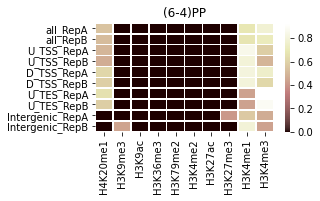

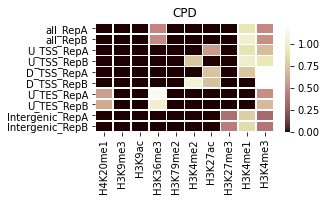

In [79]:
cellLines=['NHF1']

for cellLine in cellLines:
  if cellLine == 'GM128':
    repairTypes = ['Cisplatin']
    repairNames = ['Cisplatin']    
  elif cellLine=='HeLa':
    repairTypes = ['64pp', 'CPD']
    repairNames = ['(6-4)PP', 'CPD']    
  elif cellLine == 'NHF1':
    repairTypes = ['64pp', 'CPD']
    repairNames = ['(6-4)PP', 'CPD']

  for i, repairType in enumerate(repairTypes):
    for damageSample in damageSamples:
      fnameShapVal = '.'.join(['_'.join([cellLine, repairType, damageSample, 'ShapVal']), 'pickle'])
      with open(fnameShapVal, 'rb') as handle:
          shapVal = pickle.load(handle)

      shapVal_annot = shapVal.applymap(lambda x:'' if x==0 else str(x)[:4])
      yTicks = ['all A', 'all B',
                'U-TSS A','U-TSS B',
                'D-TSS A', 'D-TSS B',
                'U-TES A','U-TES B',
                'Intergenic A', 'Intergenic B']

      # chromatin_types = ['All','open','close']
      chromatin_types = ['All']

      fig = plt.figure(figsize = (4,2)) # width x height
      ax1 = fig.add_subplot(1, 1, 1) # row, column, position
      # ax2 = fig.add_subplot(1, 3, 2)
      # ax3 = fig.add_subplot(1, 3, 3)

      for chromatin_type  in chromatin_types:
        inds = [ind for ind in list(shapVal.index) if chromatin_type in ind]
        chromatin = shapVal.reindex(inds)
        annot = shapVal_annot.reindex(inds)

        if chromatin_type == 'All':
          sns.heatmap(chromatin, ax = ax1, linewidths=.5,cmap = "pink", cbar=True,
                      yticklabels=yTicks,fmt = '')
          ax1.set_title(repairNames[i])
          figName = '.'.join(['_'.join([repairType, damageSample, chromatin_type, 'shapImp']), 'jpeg'])

        if chromatin_type == 'open':
          sns.heatmap(chromatin, ax = ax2, linewidths=.5,cmap = "pink", cbar=False,  
                      yticklabels=False, fmt = '')
          ax2.set_title(chromatin_type)
          figName = '.'.join(['_'.join([repairType, chromatin_type, 'shapImp']), 'jpeg'])
          

        if chromatin_type == 'close':
          sns.heatmap(chromatin, ax = ax3, linewidths=.5,cmap = "pink", cbar=False,  
                      yticklabels=False,fmt = '')
          ax3.set_title(chromatin_type)
          
        extensions = ['jpeg', 'pdf']
        for ext in extensions:
          figName = '.'.join(['_'.join([cellLine, repairType, damageSample, 'shapImp']), ext])
          figDir_name = os.path.join(figDir, figName)
          plt.savefig(figDir_name, bbox_inches='tight', dpi=500)
        plt.show()


In [ ]:
dat.columns

Index(['chr', 'start', 'stop', 'CPD_A', 'CPD_B', 'H4K20me1', 'H3K9me3',
       'H3K9ac', 'H3K36me3', 'H3K79me2', 'H3K4me2', 'H3K27ac', 'H3K27me3',
       'H3K4me1', 'DNAse_I', 'H3K4me3'],
      dtype='object')